In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

In [2]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
# Building the initial Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

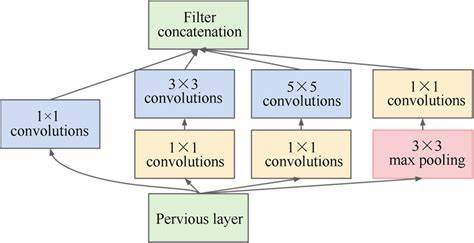

In [7]:
img2=cv2.imread('/content/drive/MyDrive/googlenetblock.jfif')
cv2_imshow(img2)

In [8]:
## Building the Inception Block
class Inception(nn.Module):
    def __init__(
        self,
        in_channels,
        num1x1,
        num3x3_reduce,         #this stands for no of 1x1 filters in the reduction layer and used before 3x3 convolution
        num3x3,
        num5x5_reduce,         #this stands for no of 1x1 filters in the reduction layer and used before 5x5 convolution
        num5x5,
        pool_proj,
    ):
        super(Inception, self).__init__()

        # Four output channel for each parallel block of network
        # within Inception the individual blocks are running parallely
        # NOT sequentially.

        #but inside block they run sequentially


        #1x1 conv block
        self.block1 = nn.Sequential(
            ConvBlock(in_channels, num1x1, kernel_size=1, stride=1, padding=0)
        )


        #1x1 and 3x3 conv block
        self.block2 = nn.Sequential(
            ConvBlock(in_channels, num3x3_reduce, kernel_size=1, stride=1, padding=0),
            ConvBlock(num3x3_reduce, num3x3, kernel_size=3, stride=1, padding=1),
        )


        # 1x1 and 5x5 conv block
        self.block3 = nn.Sequential(
            ConvBlock(in_channels, num5x5_reduce, kernel_size=1, stride=1, padding=0),
            ConvBlock(num5x5_reduce, num5x5, kernel_size=5, stride=1, padding=2),
        )

        #3x3 maxpool and 1x1 conv block
        self.block4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            ConvBlock(in_channels, pool_proj, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        # Note the different way this forward function
        # calculates the output.
        block1 = self.block1(x)
        block2 = self.block2(x)
        block3 = self.block3(x)
        block4 = self.block4(x)

        return torch.cat([block1, block2, block3, block4], 1)    #concatenation of all blocks 

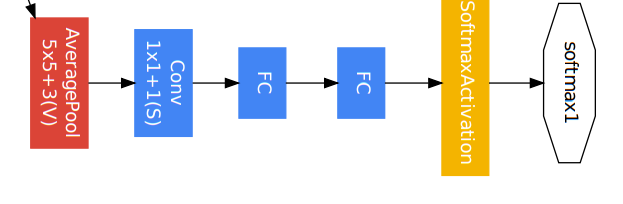

In [9]:
img3=cv2.imread('/content/drive/MyDrive/auxiliaryblock.png')
cv2_imshow(img3)

In [10]:
##Auxiliary class

class Auxiliary(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()

        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.activation = nn.ReLU()

        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.pool(x)

        out = self.conv(out)
        out = self.activation(out)
        print('out shape is  ', out.shape)
        # out shape is  torch.Size([2, 128, 4, 4])

        out = torch.flatten(out, 1)   #necessary bcz convolution will output 4 dimensional  
                                      #tensor but fc that is nn.linear require 2 dimensional

        out = self.fc1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)

        return out

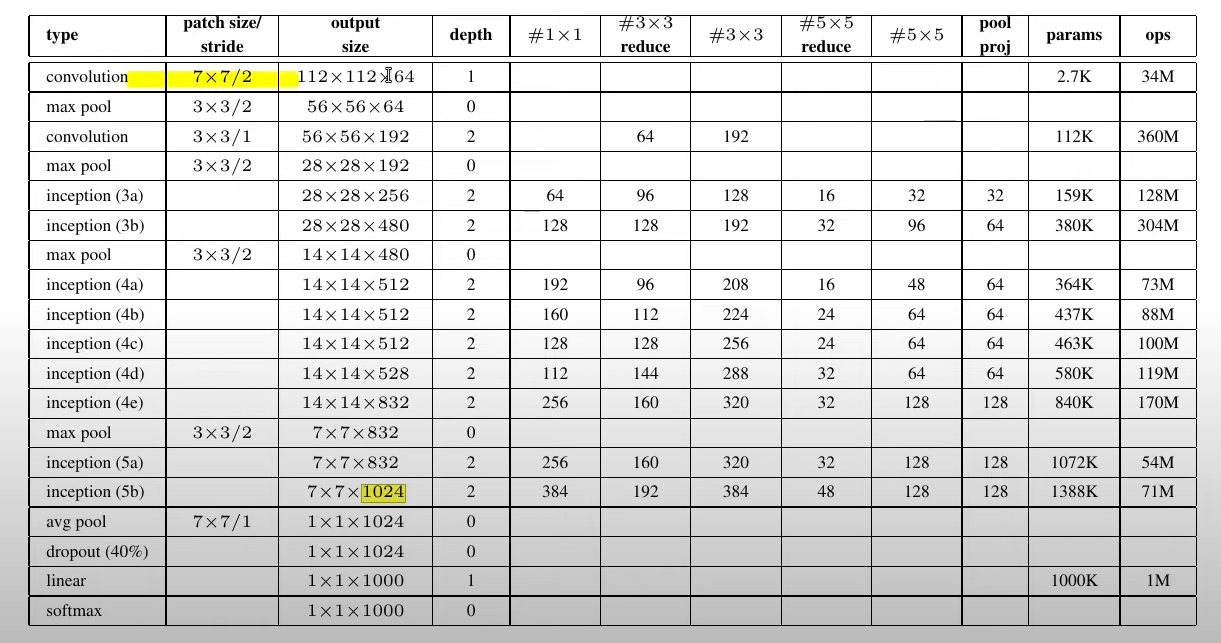

In [11]:
img4=cv2.imread('/content/drive/MyDrive/infotable.png')
cv2_imshow(img4)

In [12]:
# implementation of googlenet

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()


        #stem part
        self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = ConvBlock(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)


        #9 inception blocks
        self.inception3A = Inception(
            in_channels=192,
            num1x1=64,
            num3x3_reduce=96,
            num3x3=128,
            num5x5_reduce=16,
            num5x5=32,
            pool_proj=32,
        )
        self.inception3B = Inception(
            in_channels=256,
            num1x1=128,
            num3x3_reduce=128,
            num3x3=192,
            num5x5_reduce=32,
            num5x5=96,
            pool_proj=64,
        )
        self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

        self.inception4A = Inception(
            in_channels=480,
            num1x1=192,
            num3x3_reduce=96,
            num3x3=208,
            num5x5_reduce=16,
            num5x5=48,
            pool_proj=64,
        )
        self.inception4B = Inception(
            in_channels=512,
            num1x1=160,
            num3x3_reduce=112,
            num3x3=224,
            num5x5_reduce=24,
            num5x5=64,
            pool_proj=64,
        )
        self.inception4C = Inception(
            in_channels=512,
            num1x1=128,
            num3x3_reduce=128,
            num3x3=256,
            num5x5_reduce=24,
            num5x5=64,
            pool_proj=64,
        )
        self.inception4D = Inception(
            in_channels=512,
            num1x1=112,
            num3x3_reduce=144,
            num3x3=288,
            num5x5_reduce=32,
            num5x5=64,
            pool_proj=64,
        )
        self.inception4E = Inception(
            in_channels=528,
            num1x1=256,
            num3x3_reduce=160,
            num3x3=320,
            num5x5_reduce=32,
            num5x5=128,
            pool_proj=128,
        )
        self.pool5 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

        self.inception5A = Inception(
            in_channels=832,
            num1x1=256,
            num3x3_reduce=160,
            num3x3=320,
            num5x5_reduce=32,
            num5x5=128,
            pool_proj=128,
        )
        self.inception5B = Inception(
            in_channels=832,
            num1x1=384,
            num3x3_reduce=192,
            num3x3=384,
            num5x5_reduce=48,
            num5x5=128,
            pool_proj=128,
        )
        self.pool6 = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        self.aux4A = Auxiliary(512, num_classes)
        self.aux4D = Auxiliary(528, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.pool3(out)
        out = self.inception3A(out)
        out = self.inception3B(out)
        out = self.pool4(out)
        out = self.inception4A(out)

        aux1 = self.aux4A(out)

        out = self.inception4B(out)
        out = self.inception4C(out)
        out = self.inception4D(out)

        aux2 = self.aux4D(out)

        out = self.inception4E(out)
        out = self.pool5(out)
        out = self.inception5A(out)
        out = self.inception5B(out)
        out = self.pool6(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)

        return out, aux1, aux2

In [13]:
#data loader
BATCH_SIZE=128
def dataloader():
 transform = transforms.Compose([
          transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])
          ])

 train_dataset = datasets.FashionMNIST(root='data', 
                               train=True, 
                               transform=transform,
                               download=True)
 train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)



 test_dataset = datasets.FashionMNIST(root='data', 
                              train=False, 
                              transform=transform)
 test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

 print("Training set : {} images".format(len(train_dataset)))
 print("Test set : {} images".format(len(test_dataset)))

 return train_loader , test_loader

In [14]:
train_loader , test_loader = dataloader()


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Training set : 60000 images
Test set : 10000 images


In [15]:
def train_model(model, train_loader, criterion, optimizer):
    EPOCHS = 5
    train_samples_num = 60000

    train_epoch_loss_history = []

    for epoch in range(EPOCHS):

        train_running_loss = 0
        correct_train = 0

        model.train().cuda()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

          
            optimizer.zero_grad()

            # Start the forward pass
            prediction0, aux_pred_1, aux_pred_2 = model(inputs)

            # Compute the loss.
            real_loss = criterion(prediction0, labels)
            aux_loss_1 = criterion(aux_pred_1, labels)
            aux_loss_2 = criterion(aux_pred_2, labels)

            loss = real_loss + 0.3 * aux_loss_1 + 0.3 * aux_loss_2

            # do backpropagation and update weights with step()# Backward pass.
            loss.backward()
            optimizer.step()

            # Update the running corrects
            _, predicted = torch.max(prediction0.data, 1)

            correct_train += (predicted == labels).float().sum().item()

          
            train_running_loss += loss.data.item() * inputs.shape[0]

        train_epoch_loss = train_running_loss / train_samples_num

        train_epoch_loss_history.append(train_epoch_loss)

        train_acc = correct_train / train_samples_num

        
        info = "[For Epoch {}/{}]: train-loss = {:0.5f} | train-acc = {:0.3f}"

        print(
            info.format(
                epoch + 1, EPOCHS, train_epoch_loss, train_acc
            )
        )

        

    return train_epoch_loss_history

In [16]:
model = GoogLeNet()
model.to(device)

GoogLeNet(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): ConvBlock(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3A): Inception(
    (block1): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
train_epoch_loss_history = train_model(model, train_loader,  criterion, optimizer)


RuntimeError: ignored